In [1]:
import jax
import jax.numpy         as jnp
import numpy             as np
import matplotlib.pyplot as plt
import seaborn           as sns
import xarray            as xr
import h5py

import jax_cfd.base       as cfd
import jax_cfd.base.grids as grids
import jax_cfd.spectral   as spectral

import dataclasses

In [2]:
# Set simulation parameters
viscosity     = 1e-3
max_velocity  = 7.
cfl           = 0.5
final_time    = 30.
x_min         = 0.
x_max         = 2. * jnp.pi
nx            = 256
y_min         = x_min
y_max         = x_max
ny            = nx
dx            = (x_max - x_min) / nx
init_kmaxdx   = jnp.pi / 30
init_kmax     = init_kmaxdx / dx
seed          = 42                            # seed for random number generation
smooth        = True                          # use anti-aliasing
nb_snapshots  = 512                           # nb of snapshots in generated dataset
first_ignored = int(nb_snapshots // 10)       # nb of ignored snapshots from the simulation start
outer_steps   = first_ignored + nb_snapshots  # nb of snapshots in VRAM at   the simulation end

# Define grid
grid = grids.Grid(
  (nx, ny),
  domain=((x_min, x_max), (y_min, y_max))
)

# Set time step
dt = cfd.equations.stable_time_step(max_velocity, cfl, viscosity, grid)

# Set time integration
step_fn = spectral.time_stepping.crank_nicolson_rk4(
  spectral.equations.ForcedNavierStokes2D(viscosity, grid, smooth=smooth), dt
)

# Set number of time steps
# between two consecutive snapshots
# in the dataset that will be generated
inner_steps = int((final_time // dt) // outer_steps)

print(f"inner_steps: {inner_steps}")

# Set trajectory function
# to save snapshots
trajectory_fn = cfd.funcutils.trajectory(
  cfd.funcutils.repeated(step_fn, inner_steps), outer_steps
)

# Set initial condition
v0 = cfd.initial_conditions.filtered_velocity_field(
  jax.random.PRNGKey(seed), grid, max_velocity, init_kmax
)
vorticity0     = cfd.finite_differences.curl_2d(v0).data
vorticity_hat0 = jnp.fft.rfftn(vorticity0)

# Compute time series in spectral space
_, trajectory = trajectory_fn(vorticity_hat0)

# Convert time series to vorticity space
vorticity_space = jnp.fft.irfftn(trajectory, axes=(1, 2))

print("Completed simulation!")

inner_steps: 30
Completed simulation!


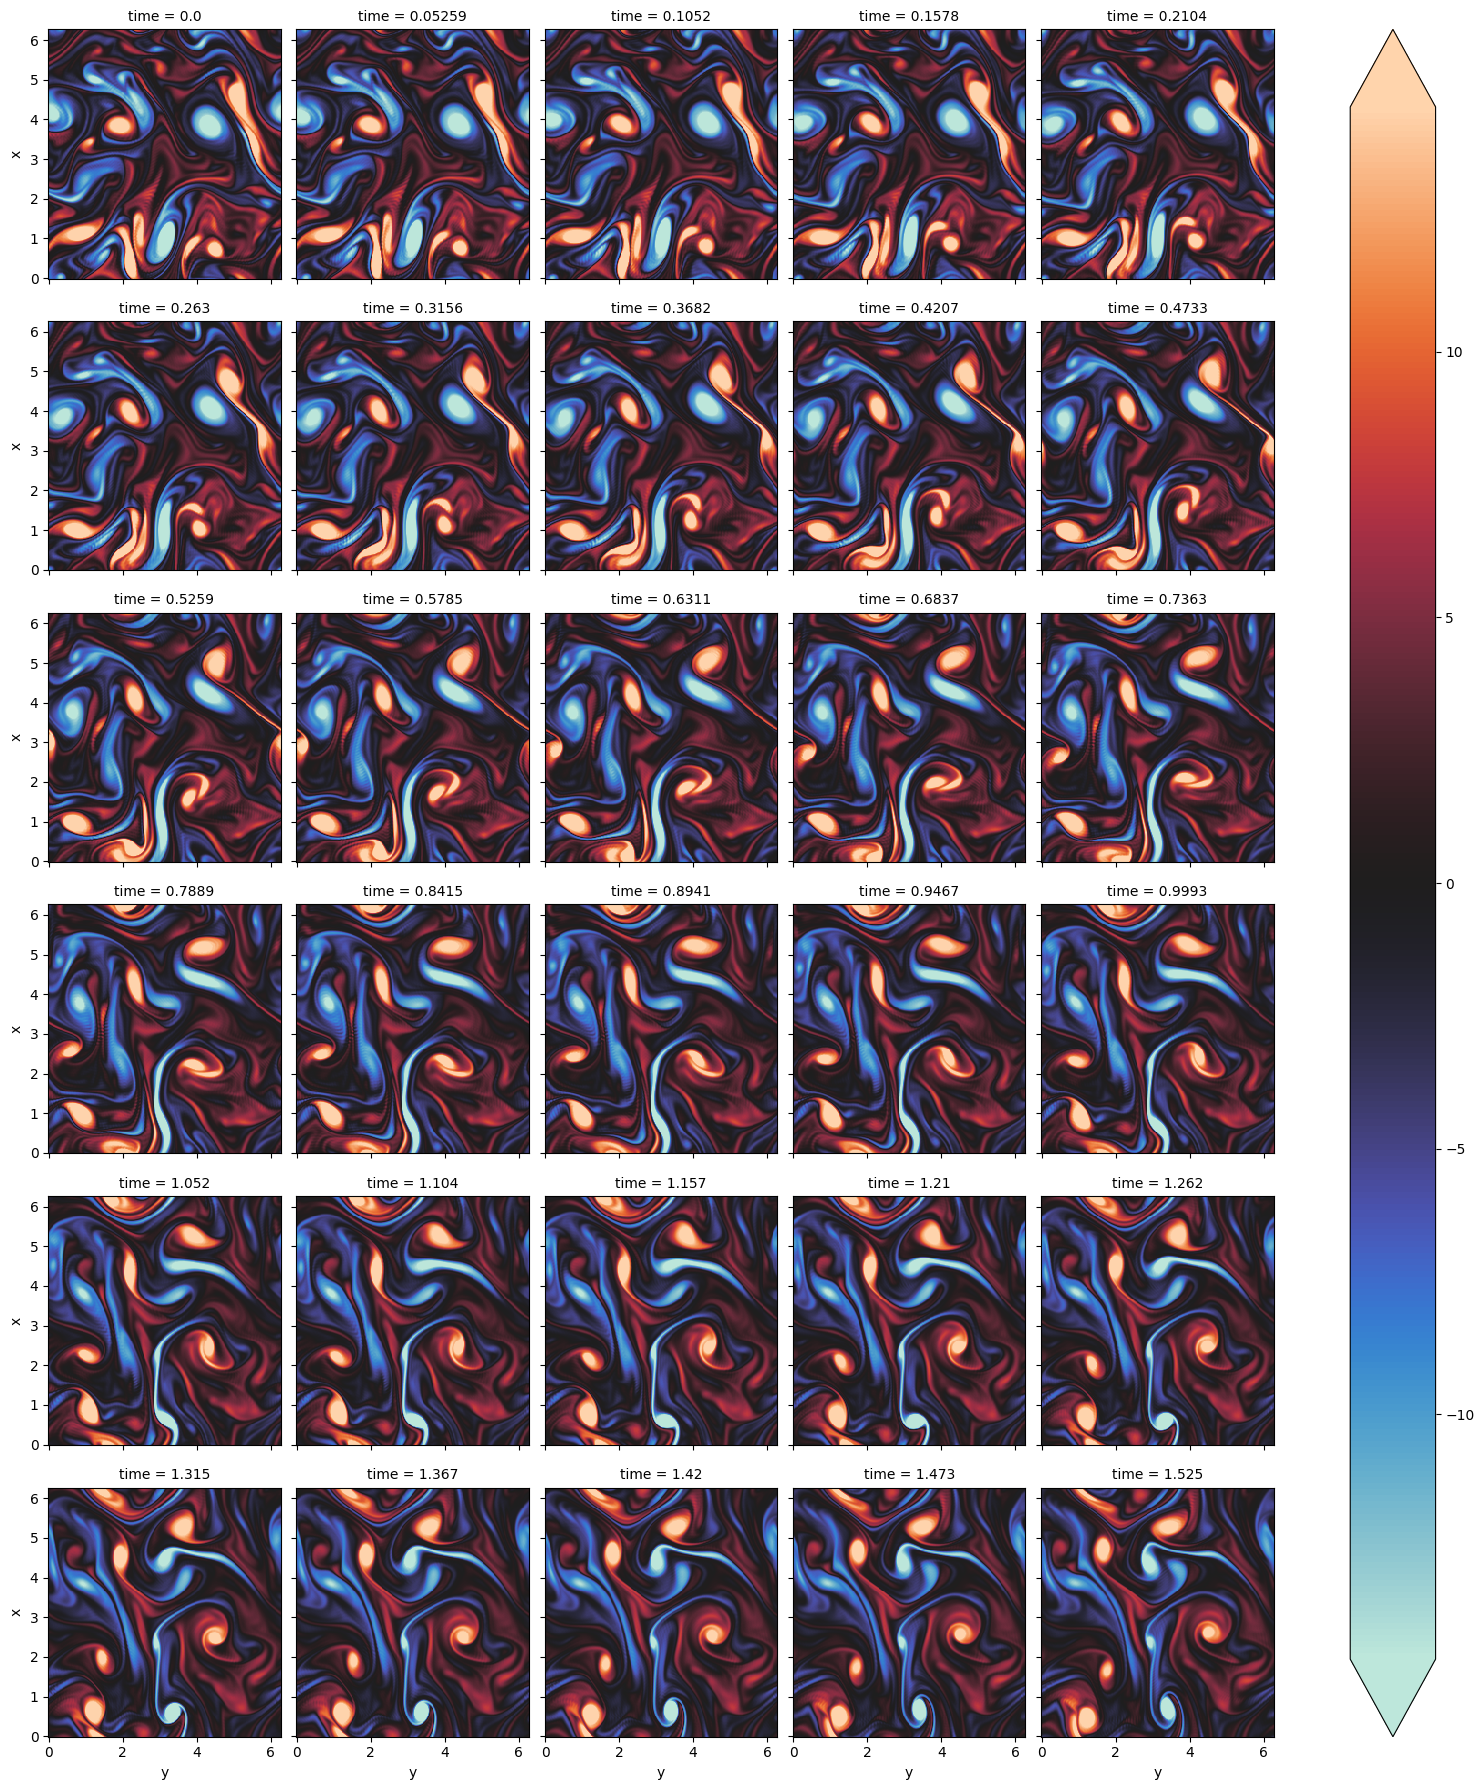

In [3]:
# Plot simulation results
coords   = jnp.arange(nx) * dx
nsnaps   = min(nb_snapshots, 30)
coordsxr = {
  'time': dt * jnp.arange(nsnaps) * inner_steps,
  'x': coords,
  'y': coords,
}
snaps = xr.DataArray(
  vorticity_space[first_ignored:first_ignored+nsnaps], 
  dims=["time", "x", "y"], coords=coordsxr
).plot.imshow(
  col='time', col_wrap=5, cmap=sns.cm.icefire, robust=True
)
snaps.fig.savefig("data.png", dpi=300, bbox_inches="tight")

In [4]:
# Save simulation data to HDF5 file
# shape: (nb_snapshots, nx, ny)
vs = np.array(vorticity_space[first_ignored:])
print(vs.shape, vs.dtype, type(vs))
assert vs.shape[0] == nb_snapshots

with h5py.File("data.h5", "w") as f:
    f.create_dataset("data", data=vs)

(512, 256, 256) float32 <class 'numpy.ndarray'>


In [19]:
# Save as RGB .png the first snapshot from dataset
from PIL import Image
idx    = 0
vs_rgb = np.stack([vs[idx,:] for i in range(3)], -1).astype(np.uint8)
print(vs_rgb.shape)
im     = Image.fromarray(vs_rgb, "RGB")
im.save(f"lr_image.png")

(256, 256, 3)
